In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

🔄 Memproses semua audio...
✅ Ekstraksi selesai.
🚀 Mulai training model CNN...
Epoch 1/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.1687 - loss: 6.6117 - val_accuracy: 0.3547 - val_loss: 1.7715
Epoch 2/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4421 - loss: 1.5680 - val_accuracy: 0.4877 - val_loss: 1.4992
Epoch 3/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5655 - loss: 1.2291 - val_accuracy: 0.6523 - val_loss: 1.0620
Epoch 4/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6438 - loss: 1.0159 - val_accuracy: 0.6954 - val_loss: 0.9323
Epoch 5/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6934 - loss: 0.8845 - val_accuracy: 0.7156 - val_loss: 0.8574
Epoch 6/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7495 - loss: 0.7221 - val_accuracy: 0.7473 - val_loss: 0.7606
Epoch 7/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7709 - loss: 0.6547 - val_accuracy: 0.7473 - val_loss: 0.8143
Epoch 8/30
198/198 ━━━━━━

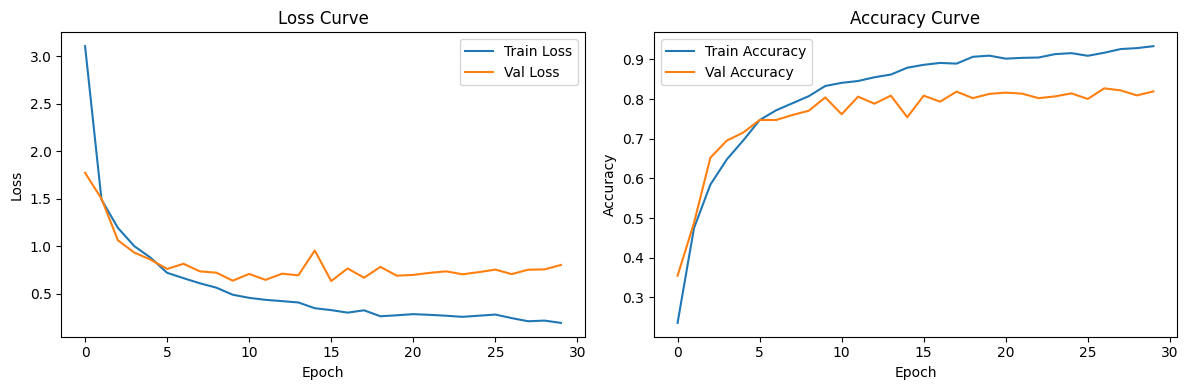

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


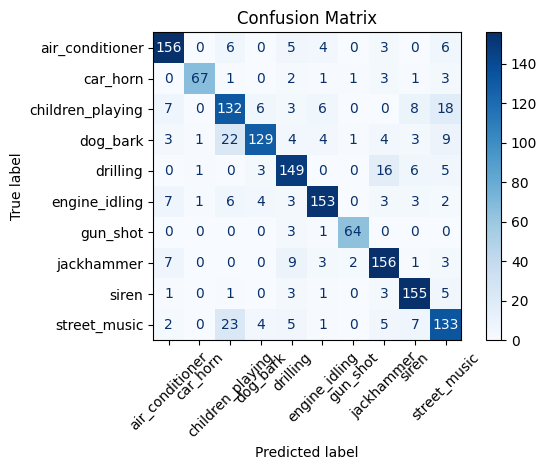

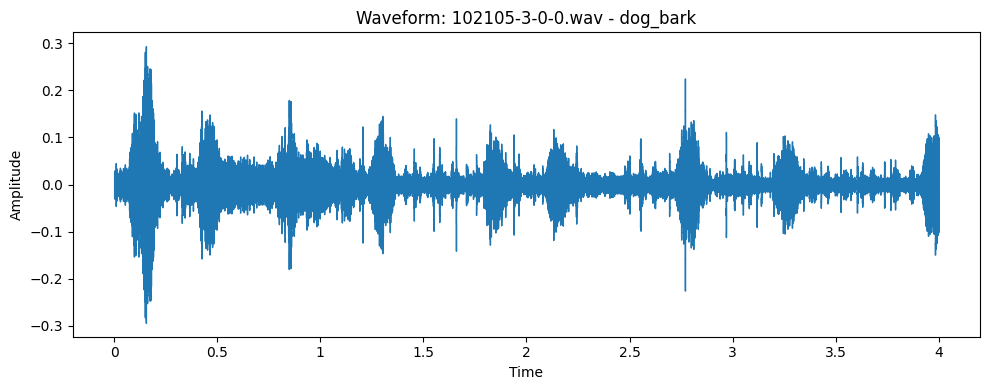

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
🔊 Prediksi file 102105-3-0-0.wav: dog_bark


In [11]:
# 📦 IMPORT LIBRARY
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# 📁 PATH DATASET
metadata_path = "/kaggle/input/urbansound8k/UrbanSound8K.csv"
audio_base_path = "/kaggle/input/urbansound8k"

assert os.path.exists(metadata_path), "Metadata tidak ditemukan"
assert os.path.exists(audio_base_path), "Folder audio tidak ditemukan"

# 📑 LOAD METADATA
df = pd.read_csv(metadata_path)
df_filtered = df[df['fold'].isin(range(1, 10))]  # gunakan fold1–fold9

# 🔧 PARAMETER AUDIO
SAMPLE_RATE = 22050
DURATION = 4  # dalam detik
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
N_MFCC = 40
FIXED_LENGTH = 173  # padding panjang time-step MFCC (tergantung sampling rate dan hop_length)

# 🎧 EKSTRAKSI FITUR MFCC UNTUK CNN
X = []
y = []

print("🔄 Memproses semua audio...")

for _, row in df_filtered.iterrows():
    fold = f"fold{row['fold']}"
    file_name = row['slice_file_name']
    label = row['class']
    path = os.path.join(audio_base_path, fold, file_name)
    
    try:
        signal, sr = librosa.load(path, sr=SAMPLE_RATE)
        
        if len(signal) < SAMPLES_PER_TRACK:
            padding = SAMPLES_PER_TRACK - len(signal)
            signal = np.pad(signal, (0, padding), mode='constant')
        else:
            signal = signal[:SAMPLES_PER_TRACK]

        # Ekstraksi MFCC
        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=N_MFCC)
        mfcc = mfcc.T

        if mfcc.shape[0] < FIXED_LENGTH:
            pad_width = FIXED_LENGTH - mfcc.shape[0]
            mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
        elif mfcc.shape[0] > FIXED_LENGTH:
            mfcc = mfcc[:FIXED_LENGTH, :]

        X.append(mfcc)
        y.append(label)
    except Exception as e:
        print(f"⚠️ Gagal memproses {path}: {e}")

print("✅ Ekstraksi selesai.")

# 🔣 ENKODE LABEL & SPLIT
X = np.array(X)
X = X[..., np.newaxis]  # tambahkan dimensi channel
y = np.array(y)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.2, stratify=y_encoded, random_state=42
)

# 🧠 MODEL CNN UNTUK AUDIO CLASSIFICATION
model = Sequential([
    Input(shape=(FIXED_LENGTH, N_MFCC, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# ⚙️ KOMPILE & LATIH MODEL
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

print("🚀 Mulai training model CNN...")
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# 🧪 EVALUASI MODEL
loss, acc = model.evaluate(X_test, y_test)
print(f"\n🎯 Akurasi model CNN: {acc * 100:.2f}%")

# 💾 SIMPAN MODEL
model.save("urban_cnn_model.h5")
print("💾 Model disimpan ke urban_cnn_model.h5")

# 📈 VISUALISASI AKURASI & LOSS
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# 📊 CONFUSION MATRIX
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# 🎼 VISUALISASI AUDIO CONTOH
sample_row = df_filtered[df_filtered['fold'] == 3].iloc[0]
sample_path = os.path.join(audio_base_path, f"fold{sample_row['fold']}", sample_row['slice_file_name'])
signal, sr = librosa.load(sample_path)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(signal, sr=sr)
plt.title(f"Waveform: {sample_row['slice_file_name']} - {sample_row['class']}")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

# 🔍 PREDIKSI SATU FILE AUDIO
signal, sr = librosa.load(sample_path, sr=SAMPLE_RATE)
if len(signal) < SAMPLES_PER_TRACK:
    signal = np.pad(signal, (0, SAMPLES_PER_TRACK - len(signal)), mode='constant')
else:
    signal = signal[:SAMPLES_PER_TRACK]

mfcc_pred = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=N_MFCC).T
if mfcc_pred.shape[0] < FIXED_LENGTH:
    mfcc_pred = np.pad(mfcc_pred, ((0, FIXED_LENGTH - mfcc_pred.shape[0]), (0, 0)), mode='constant')
elif mfcc_pred.shape[0] > FIXED_LENGTH:
    mfcc_pred = mfcc_pred[:FIXED_LENGTH, :]

mfcc_pred = mfcc_pred[np.newaxis, ..., np.newaxis]
prediction = model.predict(mfcc_pred)
label_pred = label_encoder.inverse_transform([np.argmax(prediction)])
print(f"🔊 Prediksi file {sample_row['slice_file_name']}: {label_pred[0]}")
